/root/miniconda3/envs/FBQA_Hydrogen/lib/python3.10/site-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.3 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


-0.09706626816763125 * I(0) + 0.17141282644776926 * Z(0) + 0.1714128264477692 * Z(1) + -0.22343153690813433 * Z(2) + -0.22343153690813433 * Z(3) + 0.16868898170361205 * (Z(0) @ Z(1)) + 0.12062523483390411 * (Z(0) @ Z(2)) + 0.16592785033770338 * (Z(0) @ Z(3)) + 0.16592785033770338 * (Z(1) @ Z(2)) + 0.12062523483390411 * (Z(1) @ Z(3)) + 0.17441287612261575 * (Z(2) @ Z(3)) + -0.04530261550379926 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04530261550379926 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.04530261550379926 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04530261550379926 * (Y(0) @ Y(1) @ X(2) @ X(3))
第 1 步: E = -0.09719961 Ha, β_1 = 0.020807
第 2 步: E = -0.09727219 Ha, β_2 = 0.019135
第 3 步: E = -0.09729318 Ha, β_3 = 0.017314
第 4 步: E = -0.09727419 Ha, β_4 = 0.015392
第 5 步: E = -0.09722827 Ha, β_5 = 0.013412
第 6 步: E = -0.09716891 Ha, β_6 = 0.011409
第 7 步: E = -0.09710928 Ha, β_7 = 0.009413
第 8 步: E = -0.09706157 Ha, β_8 = 0.007447
第 9 步: E = -0.09703654 Ha, β_9 = 0.005531
第 10 步: E = -0.09704315 Ha, β_10 = 0.00

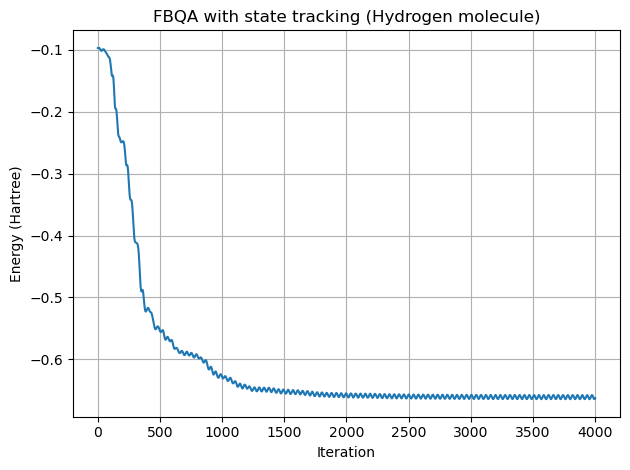

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import molecule
from pennylane import commutator
import matplotlib.pyplot as plt

# 1. 设置分子结构
from pennylane.qchem import molecular_hamiltonian

from pyscf import gto, scf
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator
import scipy

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_sparse_operator

# Step 1: 构造 OpenFermion 分子对象（不要用 PySCF 的 gto.Mole）
geometry = [('H', (0.0, 0.0, 0.0)),
            ('H', (0.0, 0.0, 0.74))]  # 单位为 Å
basis = 'sto-3g'
multiplicity = 1
charge = 0

molecule = MolecularData(
    geometry=geometry,
    basis=basis,
    multiplicity=multiplicity,
    charge=charge
)

# Step 2: 运行 PySCF 计算（RHF + 哈密顿量）
molecule = run_pyscf(molecule, run_scf=True)

# Step 3: Jordan-Wigner 变换为 Qubit Hamiltonian
fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)

# Step 4: 转换为稀疏矩阵（如需矩阵形式演化）
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian

def openfermion_to_qml_hamiltonian(qubit_op, n_qubits):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else qml.prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))  # 只保留实部
    return Hamiltonian(coeffs, ops)

# 调用转换函数
n_qubits = molecule.n_qubits
H_c = openfermion_to_qml_hamiltonian(qubit_hamiltonian, n_qubits)

print(H_c)
# 输出 qubit Hamiltonian（OpenFermion 格式）



'''
# 2. 分子哈密顿量（cost Hamiltonian）
H_c, qubits = qml.qchem.molecular_hamiltonian(
    symbols, coordinates, method='pyscf', basis='sto-3g'
)
print("Qubits:", qubits)
print(H_c)
'''
# 3. Driver Hamiltonian
def build_driver_h(n):
    return qml.Hamiltonian([-1.0] * n, [qml.PauliY(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

# 4. 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)

# 5. 初始化量子态：|+>^n
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev)
def plus_state():
    for w in range(n_qubits):
        qml.Hadamard(w)
    return qml.state()

# 6. 单步 FALQON 演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(n_qubits))

# 7. 测量期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

#check consistence 
#measure the exp maybe change collapse wave function

# 8. 主流程：状态保留式 FALQON
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()

    for i in range(n_steps):
        # 计算 feedback beta
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -delta_t * exp_comm
        beta_list.append(next_beta)

        # 应用下一步 unitary
        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        # 计算能量
        energy = measure_expectation(state, H)
        energy_list.append(energy)

        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

# 9. 设置参数并运行
n_steps = 4000
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa_state_tracking(H_c, driver_h, comm_h, n_steps, beta_1, delta_t)

# 10. 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import commutator
from pennylane import PauliX, PauliY, PauliZ, Identity, Hamiltonian, prod
import matplotlib.pyplot as plt

from openfermion import MolecularData
from openfermionpyscf import run_pyscf
from openfermion.transforms import jordan_wigner

# Step 1: PySCF 构建分子 + OpenFermion 哈密顿量
geometry = [('H', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 0.74))]
basis = 'sto-3g'
molecule = MolecularData(geometry, basis, multiplicity=1, charge=0)
molecule = run_pyscf(molecule, run_scf=True)

fermionic_hamiltonian = molecule.get_molecular_hamiltonian()
qubit_hamiltonian = jordan_wigner(fermionic_hamiltonian)
n_qubits = molecule.n_qubits

# Step 2: 转换为 PennyLane 的 Hamiltonian 格式
def openfermion_to_qml_hamiltonian(qubit_op):
    coeffs = []
    ops = []
    for term, coef in qubit_op.terms.items():
        if len(term) == 0:
            ops.append(Identity(0))
        else:
            op_list = []
            for qubit_idx, pauli in term:
                if pauli == 'X':
                    op_list.append(PauliX(qubit_idx))
                elif pauli == 'Y':
                    op_list.append(PauliY(qubit_idx))
                elif pauli == 'Z':
                    op_list.append(PauliZ(qubit_idx))
            op = op_list[0] if len(op_list) == 1 else prod(*op_list)
            ops.append(op)
        coeffs.append(np.real(coef))
    return Hamiltonian(coeffs, ops)

H_c = openfermion_to_qml_hamiltonian(qubit_hamiltonian)
print(H_c)

# Step 3: Driver Hamiltonian (Y 型)
def build_driver_h(n):
    return Hamiltonian([-1.0] * n, [PauliY(i) for i in range(n)])

driver_h = build_driver_h(n_qubits)

# Step 4: 构造 commutator 哈密顿量
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []
    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()
    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue
                comm_terms.append(1j * c1 * c2 * comm)
            except Exception as e:
                print(f"跳过 [{op1}, {op2}]：{e}")
                continue
    return sum(comm_terms).simplify()

comm_h = build_commutator_hamiltonian(driver_h, H_c)

# Step 5: 初始化量子态 |+>^n
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def plus_state():
    for i in range(n_qubits):
        qml.Hadamard(i)
    return qml.state()

# Step 6: 单步演化矩阵
def single_falqon_unitary(beta_k, delta_t, cost_h, driver_h):
    U_cost = qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    U_driver = qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)
    return qml.matrix(U_driver @ U_cost, wire_order=range(n_qubits))

# Step 7: 计算期望值 ⟨ψ|H|ψ⟩
def measure_expectation(state, H):
    H_mat = qml.matrix(H, wire_order=range(n_qubits))
    return np.real(np.vdot(state, H_mat @ state))

# Step 8: FALQON 主流程（带 eta 参数）
def run_fbqa_state_tracking(H, driver_h, comm_h, n_steps, beta_1, delta_t, eta=1.0):
    beta_list = [beta_1]
    energy_list = []

    state = plus_state()
    min_energy = float("inf")

    for i in range(n_steps):
        exp_comm = measure_expectation(state, comm_h)
        next_beta = -eta * delta_t * exp_comm
        beta_list.append(next_beta)

        U_k = single_falqon_unitary(next_beta, delta_t, H, driver_h)
        state = U_k @ state

        energy = measure_expectation(state, H)
        energy_list.append(energy)
        if energy < min_energy:
            min_energy = energy

        if i % 100 == 0 or i == n_steps - 1:
            print(f"Step {i+1}: Energy = {energy:.8f} Ha, β = {next_beta:.6f}")

    print(f"\n最优能量 ≈ {min_energy:.8f} Ha")
    return beta_list, energy_list

# Step 9: 参数设置并运行
n_steps = 4000
delta_t = 0.05  # 更小步长提高精度
beta_1 = 0.0
eta = 1.0       # 可调学习率

res_beta, res_energies = run_fbqa_state_tracking(H_c, driver_h, comm_h, n_steps, beta_1, delta_t, eta=eta)

# Step 10: 可视化
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("FBQA with state tracking (Hydrogen molecule)")
plt.grid(True)
plt.tight_layout()
plt.show()


-0.09706626816763125 * I(0) + 0.17141282644776926 * Z(0) + 0.1714128264477692 * Z(1) + -0.22343153690813433 * Z(2) + -0.22343153690813433 * Z(3) + 0.16868898170361205 * (Z(0) @ Z(1)) + 0.12062523483390411 * (Z(0) @ Z(2)) + 0.16592785033770338 * (Z(0) @ Z(3)) + 0.16592785033770338 * (Z(1) @ Z(2)) + 0.12062523483390411 * (Z(1) @ Z(3)) + 0.17441287612261575 * (Z(2) @ Z(3)) + -0.04530261550379926 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04530261550379926 * (X(0) @ Y(1) @ Y(2) @ X(3)) + 0.04530261550379926 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04530261550379926 * (Y(0) @ Y(1) @ X(2) @ X(3))
Step 1: Energy = -0.09710281 Ha, β = 0.010404
Step 101: Energy = -0.09895097 Ha, β = 0.006481
Step 201: Energy = -0.11006821 Ha, β = -0.019773
Step 301: Energy = -0.16268392 Ha, β = -0.020522
Step 401: Energy = -0.20708630 Ha, β = 0.003618
Step 501: Energy = -0.27776563 Ha, β = -0.047807
Step 601: Energy = -0.38901546 Ha, β = -0.006515
Step 701: Energy = -0.44687665 Ha, β = -0.011285
Step 801: Energy = -0.50885773